In [1]:
#import packages
from time import time
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, KMeansSMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
#reading data
df = pd.read_csv("fake_job_postings.csv")

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
#Function to preprocess
def preprocess(df):
    df = df[df.location.notnull()]
    df= df[df.location.str.contains("US,")] 
    return df

df = preprocess(df) 

In [5]:
df = df[['description', 'fraudulent']]
df_scraped = pd.read_csv("scraped_data.csv")
df_scraped['description'] = df_scraped['title'] + df_scraped['description']
df_scraped = df_scraped[['description', 'fraudulent']]

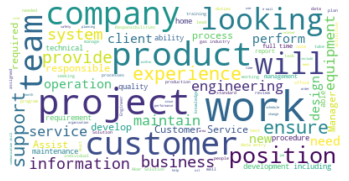

In [6]:
df_Fraud=df[df['fraudulent']==1]
list_of_tokens= ''
for review in df_Fraud['description']:
    token_1 = nltk.word_tokenize(review)
    list_of_tokens = list_of_tokens+ ' '.join(token_1)


wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=50, max_words=100, background_color="white").generate(list_of_tokens)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

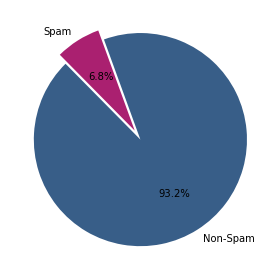

<Figure size 432x288 with 0 Axes>

In [7]:
#Function for EDA
def pie_spam(list_spam):
    count_spam = 0
    for i in list_spam:
        if i == 1:
            count_spam += 1
        else:
            pass
    count_Non_spam = len(list_spam) - count_spam
    fig_data = [count_spam, count_Non_spam]
    fig_label = ["Spam", "Non-Spam"]
    fig_explode = [0.1, 0]
    fig_color = ['#AA2070','#385E88']
    fig1, ax1 = plt.subplots()
    ax1.pie(fig_data, labels=fig_label, colors=fig_color,  explode=fig_explode, autopct='%1.1f%%', startangle=110)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"spam_pie.png")
    
isSpam=df.fraudulent.tolist()
pie_spam(isSpam)

In [8]:
def text_preprocess(document):
    
    stemmer = WordNetLemmatizer()
    document = document.lower()
    words = nltk.word_tokenize(document)
    words = [stemmer.lemmatize(word) for word in words if word.isalpha()]
    words = [word for word in words if word not in stopwords.words("english")]
    sentence = " ".join(words)
    return sentence

textList = [text for text in df.description]
processed_data_text = [text_preprocess(text) for text in textList]
df_text = pd.DataFrame({'label': isSpam , 'description': processed_data_text})
df_text

,label,description
0,0,james beard online food community curated reci...
1,0,client located houston actively seeking experi...
2,0,company esri environmental system research ins...
3,0,job title itemization review managerlocation f...
4,0,job overviewapex environmental consulting firm...
...,...,...
10588,0,flite saas display ad platform fuel world top ...
10589,0,responsibility facilitate recruiting hiring pr...
10590,0,sr javascript developer experience year locati...
10591,0,payroll accountant focus primarily payroll fun...


In [9]:
def tokenizer(doc):
    return doc

#tf-idf vectorizer
def tfidf(df_text):
    vec = TfidfVectorizer(analyzer='word', tokenizer=tokenizer, preprocessor=tokenizer, token_pattern=None,
                      min_df=2, ngram_range=(1,2), stop_words='english')
    vec.fit(df_text.description)
    train_x, test_x, train_y, test_y = train_test_split(df_text.description, df_text.label, test_size=0.2, random_state=0)
    train_x = vec.transform(train_x)
    test_x = vec.transform(test_x)
    return train_x,train_y, test_x, test_y

train_x,train_y, test_x, test_y = tfidf(df_text)

#SMOTE oversample
def smote(train_x, train_y):
    smt = KMeansSMOTE(random_state=42, k_neighbors = 72, cluster_balance_threshold = 0.05)
    train_x,train_y = smt.fit_resample(train_x,train_y)
    return train_x,train_y

train_x,train_y = smote(train_x,train_y)

/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


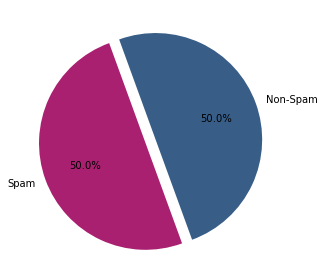

<Figure size 432x288 with 0 Axes>

In [10]:
pie_spam(train_y)

In [11]:
modelList = ['Naive Bayes', 'Random Forest', 'Linear SVM', 'Logistic Regression', 'Gradient Boosting']
accuracyList = []
f1List = []

In [12]:
#Naive Bayes Model
def naiveb(train_x, train_y, test_x, test_y):
    model = BernoulliNB()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Naive Bayes:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred ), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = naiveb(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Naive Bayes:::
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      1986
           1       0.08      0.36      0.13       133

    accuracy                           0.69      2119
   macro avg       0.51      0.54      0.47      2119
weighted avg       0.89      0.69      0.77      2119



In [13]:
#Random Forest Model
def rfmodel(train_x, train_y, test_x, test_y):
    model = RandomForestClassifier(n_estimators=500, max_depth=6, bootstrap=True, random_state=0,class_weight = 'balanced')
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Random Forestl:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred,), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = rfmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Random Forestl:::
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1986
           1       0.71      0.32      0.44       133

    accuracy                           0.95      2119
   macro avg       0.83      0.65      0.71      2119
weighted avg       0.94      0.95      0.94      2119



In [14]:
#Linear SVM Model
def svmmodel(train_x, train_y, test_x, test_y):
    model = LinearSVC(random_state = 0, penalty = 'l1', dual = False)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("SVM:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = svmmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

SVM:::
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1986
           1       0.36      0.53      0.43       133

    accuracy                           0.91      2119
   macro avg       0.66      0.73      0.69      2119
weighted avg       0.93      0.91      0.92      2119



/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [15]:
#Logistic Regression Model
def lrmodel(train_x, train_y, test_x, test_y):
    model = LogisticRegression(random_state=0)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Logistic Regression:::")
    print(classification_report(test_y, y_pred))
    return precision_score(test_y, y_pred, pos_label=1 ), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = lrmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Logistic Regression:::
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1986
           1       0.19      0.40      0.26       133

    accuracy                           0.86      2119
   macro avg       0.57      0.64      0.59      2119
weighted avg       0.91      0.86      0.88      2119



In [16]:
#Gradient Boosting Model
def gbmodel(train_x, train_y, test_x, test_y):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Gradient Boosting:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = gbmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Gradient Boosting:::
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1986
           1       0.38      0.50      0.43       133

    accuracy                           0.92      2119
   macro avg       0.67      0.72      0.69      2119
weighted avg       0.93      0.92      0.92      2119



In [17]:
accuracyList, f1List, modelList

([0.6932515337423313,
  0.9490325625294951,
  0.9103350637092968,
  0.18996415770609318,
  0.9174138744690892],
 [0.7708549985759511,
  0.939676801375965,
  0.918490004452298,
  0.8784237720624204,
  0.92249789999901],
 ['Naive Bayes',
  'Random Forest',
  'Linear SVM',
  'Logistic Regression',
  'Gradient Boosting'])

/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


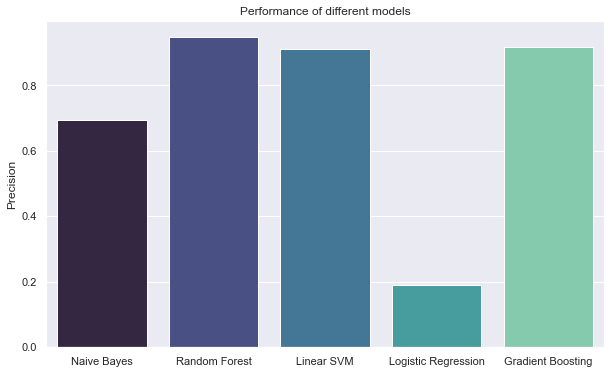

In [18]:
import seaborn
sns.set(rc={'figure.figsize':(10,6)})
tips = sns.load_dataset("tips")
g = seaborn.barplot(modelList,accuracyList, palette="mako", data= tips)
plt.title("Performance of different models")
plt.ylabel("Precision")
plt.show(g)

/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


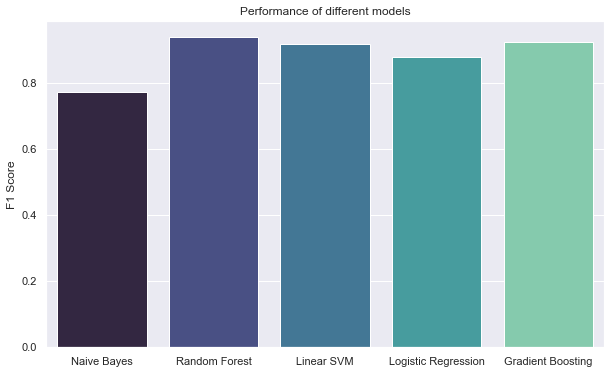

In [19]:
import seaborn
tips = sns.load_dataset("tips")
g = seaborn.barplot(modelList,f1List, palette="mako", data= tips)
plt.title("Performance of different models")
plt.ylabel("F1 Score")
plt.show(g)